<a href="https://colab.research.google.com/github/shinjinisen/data-privacy-pynb/blob/main/RecordLinkage1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy

import pandas

Find records in datasets belonging to the same entity

In [ ]:
pip install recordlinkage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.9/926.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.1 MB/s eta 0:00:00


In [ ]:
import recordlinkage
from recordlinkage.datasets import load_febrl1

In [ ]:
dfA = load_febrl1()
dfA

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-223-org,NaN,waller,6,tullaroop street,willaroo,st james,4011,wa,19081209,6988048
rec-122-org,lachlan,berry,69,giblin street,killarney,bittern,4814,qld,19990219,7364009
rec-373-org,deakin,sondergeld,48,goldfinch circuit,kooltuo,canterbury,2776,vic,19600210,2635962
rec-10-dup-0,kayla,harrington,NaN,maltby circuit,coaling,coolaroo,3465,nsw,19150612,9004242
rec-227-org,luke,purdon,23,ramsay place,mirani,garbutt,2260,vic,19831024,8099933
...,...,...,...,...,...,...,...,...,...,...
rec-188-dup-0,stephanie,geu,28,bainton crescent,masonic memorial village,maryborough,2541,sa,19421008,3997529
rec-334-dup-0,nicholas,NaN,289,britten-jonues drive,jabaru court,paddington,2000,vic,19970422,5062738
rec-469-dup-0,lachlan,katsiavos,29,paul coe cdrescent,NaN,casual,2913,nsw,19380406,4112327


It is very intuitive to start with comparing each record in DataFrame dfA with all other records in DataFrame dfA. In fact, we want to make record pairs. Each record pair should contain two different records of DataFrame dfA. This process of making record pairs is also called "indexing". With the recordlinkage module, indexing is easy. First, load the recordlinkage.Index class and call the .full method. This object generates a full index on a .index(...) call. In case of deduplication of a single dataframe, one dataframe is sufficient as input argument.

In [ ]:
indexer = recordlinkage.Index()
indexer.full()
candidate_links = indexer.index(dfA)

In [ ]:
print(len(dfA), len(candidate_links))
# (1000*1000-1000)/2 = 499500

1000 499500


Many of these record pairs do not belong to the same person. The recordlinkage toolkit has some more advanced indexing methods to reduce the number of record pairs. Obvious non-matches are left out of the index. Note that if a matching record pair is not included in the index, it can not be matched anymore.

One of the most well known indexing methods is named blocking. This method includes only record pairs that are identical on one or more stored attributes of the person (or entity in general). The blocking method can be used in the recordlinkage module.

date_of_birth vs count()

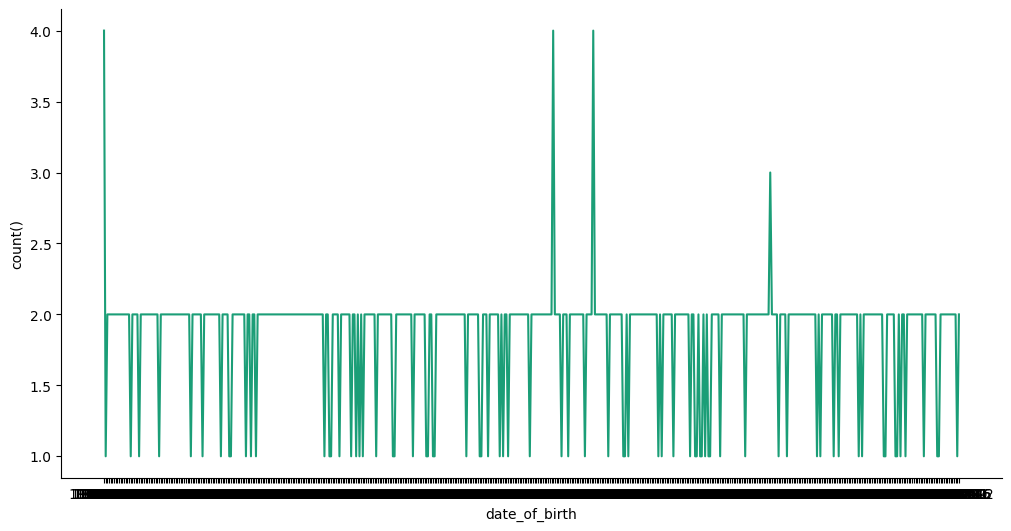

In [ ]:
# @title date_of_birth vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date_of_birth']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date_of_birth'}, axis=1)
              .sort_values('date_of_birth', ascending=True))
  xs = counted['date_of_birth']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dfA.sort_values('date_of_birth', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date_of_birth')
_ = plt.ylabel('count()')

Using record linkage to create candidate links based on blocking on the "given_name" attribute of DataFrame dfA

In [ ]:
indexer = recordlinkage.Index()
indexer.block("given_name")
candidate_links = indexer.index(dfA)
len(candidate_links)

2082

Compare records

Each record pair is a candidate match. To classify the candidate record pairs into matches and non-matches, compare the records on all attributes both records have in common.

In [ ]:
compare_cl = recordlinkage.Compare()
compare_cl.exact("given_name", "given_name", label="given_name")
compare_cl.string(
    "surname", "surname", method="jarowinkler", threshold=0.85, label="surname"
)
compare_cl.exact("date_of_birth", "date_of_birth", label="date_of_birth")
compare_cl.exact("suburb", "suburb", label="suburb")
compare_cl.exact("state", "state", label="state")
compare_cl.string("address_1", "address_1", threshold=0.85, label="address_1")
features = compare_cl.compute(candidate_links, dfA)

The comparing of record pairs starts when the compute method is called. All attribute comparisons are stored in a DataFrame with horizontally the features and vertically the record pairs.

In [ ]:
features.head(10)

given_name  surname  date_of_birth  suburb  \
rec_id_1      rec_id_2                                                    
rec-183-dup-0 rec-122-org             1      0.0              0       0   
rec-248-org   rec-122-org             1      0.0              0       0   
              rec-183-dup-0           1      0.0              0       0   
rec-122-dup-0 rec-122-org             1      1.0              1       1   
              rec-183-dup-0           1      0.0              0       0   
              rec-248-org             1      0.0              0       0   
rec-469-org   rec-122-org             1      0.0              0       0   
              rec-183-dup-0           1      0.0              0       0   
              rec-248-org             1      0.0              0       0   
              rec-122-dup-0           1      0.0              0       0   

                             state  address_1  
rec_id_1      rec_id_2                         
rec-183-dup-0 rec-122-org        0        0.0  
rec-248-org   rec-122-org        1        0.0  
              rec-183-dup-0      0        0.0  
rec-122-dup-0 rec-122-org        1        1.0  
              rec-183-dup-0      0        0.0  
              rec-248-org        1        0.0  
rec-469-org   rec-122-org        0        0.0  
              rec-183-dup-0      1        0.0  
              rec-248-org        0        0.0  
              rec-122-dup-0      0        0.0

In [ ]:
features.describe()

,given_name,surname,date_of_birth,suburb,state,address_1
count,2082.0,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000
mean,1.0,0.144092,0.139289,0.108549,0.327089,0.133045
std,0.0,0.351268,0.346331,0.311148,0.469263,0.339705
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


Step- to decide which records belong to the same person


In [ ]:
features.sum(axis=1).value_counts().sort_index(ascending=False)

6.0     142
5.0     145
4.0      30
3.0       9
2.0     376
1.0    1380
Name: count, dtype: int64

In [ ]:
matches = features[features.sum(axis=1) > 3]
matches

,,given_name,surname,date_of_birth,suburb,state,address_1
rec_id_1,rec_id_2,,,,,,
rec-122-dup-0,rec-122-org,1,1.0,1,1,1,1.0
rec-183-org,rec-183-dup-0,1,1.0,1,1,1,1.0
rec-248-dup-0,rec-248-org,1,1.0,1,1,1,1.0
rec-373-dup-0,rec-373-org,1,1.0,1,1,1,1.0
rec-10-org,rec-10-dup-0,1,1.0,1,1,1,1.0
...,...,...,...,...,...,...,...
rec-184-dup-0,rec-184-org,1,1.0,1,0,1,1.0
rec-252-org,rec-252-dup-0,1,1.0,1,1,1,1.0
rec-48-dup-0,rec-48-org,1,1.0,1,1,1,1.0


In [ ]:
from recordlinkage.preprocessing import clean, phonetic
s=pandas.Series(dfA.address_1)
print(clean(s))

rec_id
rec-223-org          tullaroop street
rec-122-org             giblin street
rec-373-org         goldfinch circuit
rec-10-dup-0           maltby circuit
rec-227-org              ramsay place
                         ...         
rec-188-dup-0        bainton crescent
rec-334-dup-0    britten jonues drive
rec-469-dup-0      paul coe cdrescent
rec-350-dup-0           harwoos court
rec-212-org       bougainville street
Name: address_1, Length: 1000, dtype: object


In [ ]:
recordlinkage.preprocessing.clean(dfA.given_name, lowercase=True, replace_by_none='[^ \\-\\_A-Za-z0-9]+', replace_by_whitespace='[\\-\\_]', strip_accents=None, remove_brackets=True, encoding='utf-8', decode_error='strict')

rec_id
rec-223-org            NaN
rec-122-org        lachlan
rec-373-org         deakin
rec-10-dup-0         kayla
rec-227-org           luke
                   ...    
rec-188-dup-0    stephanie
rec-334-dup-0     nicholas
rec-469-dup-0      lachlan
rec-350-dup-0      monique
rec-212-org            NaN
Name: given_name, Length: 1000, dtype: object

In [ ]:
recordlinkage.preprocessing.clean(dfA.date_of_birth)

rec_id
rec-223-org      19081209
rec-122-org      19990219
rec-373-org      19600210
rec-10-dup-0     19150612
rec-227-org      19831024
                   ...   
rec-188-dup-0    19421008
rec-334-dup-0    19970422
rec-469-dup-0    19380406
rec-350-dup-0    19790807
rec-212-org      19360219
Name: date_of_birth, Length: 1000, dtype: object

In [ ]:
recordlinkage.preprocessing.value_occurence(dfA.date_of_birth)

rec_id
rec-223-org      2
rec-122-org      2
rec-373-org      2
rec-10-dup-0     2
rec-227-org      2
                ..
rec-188-dup-0    2
rec-334-dup-0    2
rec-469-dup-0    2
rec-350-dup-0    2
rec-212-org      2
Name: date_of_birth, Length: 1000, dtype: int64

In [ ]:
recordlinkage.preprocessing.value_occurence(dfA.surname)

rec_id
rec-223-org       1
rec-122-org      13
rec-373-org       2
rec-10-dup-0      5
rec-227-org       2
                 ..
rec-188-dup-0     1
rec-334-dup-0    18
rec-469-dup-0     1
rec-350-dup-0     2
rec-212-org       4
Name: surname, Length: 1000, dtype: int64

In [ ]:
recordlinkage.preprocessing.phonetic(dfA['surname'], method='nysiis', concat=True, encoding='utf-8', decode_error='strict')

rec_id
rec-223-org           WALAR
rec-122-org            BARY
rec-373-org      SANDARGALD
rec-10-dup-0      HARANGTAN
rec-227-org          PARDAN
                    ...    
rec-188-dup-0             G
rec-334-dup-0           NaN
rec-469-dup-0        CATSAV
rec-350-dup-0       GARGALY
rec-212-org           MCVAG
Name: surname, Length: 1000, dtype: object